In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGeneratorMod
from segment_anything import SamAutomaticMaskGenerator as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import functions as fnc
import Layer_0 as FS_fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import time
from skimage.morphology import binary_dilation
import json
from tqdm import tqdm
import pandas as pd


In [12]:
#load image
OutDIR='/DATA/vito/output/Ravi3_run2_dw4_cp512_3b_minarea/'

with open(OutDIR+'init_para.json', 'r') as json_file:
    init_para = json.load(json_file)
with open(OutDIR+'pre_para.json', 'r') as json_file:
    pre_para = json.load(json_file)

DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=5
resample_factor=init_para.get('resample_factor')

image=fnc.load_image(DataDIR,DSname[:-2],fid)
print('Image size:', image.shape)

['/DATA/vito/data/Ravi/Ravi3_DEM_clip_07mm_segment_ids.npy', '/DATA/vito/data/Ravi/Ravi3_DEM_clip_07mm_segment_vis.npy', '/DATA/vito/data/Ravi/Ravi2_orthomosaic_02mm.png', '/DATA/vito/data/Ravi/label', '/DATA/vito/data/Ravi/Ravi4_orthomosaic_clip_02mm.tif', '/DATA/vito/data/Ravi/Ravi3_orthomosaic_clip_02mm.tif']
Ravi3_orthomosaic_clip_02mm.tif imported
Image size: (28382, 32563, 3)


In [15]:
id_mask=np.load(OutDIR+'Third/all_mask_third_pass_id.npy')
id_mask=fnc.resample_fnc(id_mask.astype(np.uint16),{'target_size': image.shape[:-1][::-1],'method': 'nearest'})

In [14]:
MODEL_TYPE = "vit_b"
DEVICE, CHECKPOINT_PATH=fnc.set_sam(MODEL_TYPE, DataDIR)
sam = sam_model_registry[MODEL_TYPE](checkpoint='/DATA/vito/MetaSAM/sam_vit_b_01ec64.pth')
sam.to(device=DEVICE)


Currently running on GPU
Model vit_b


/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


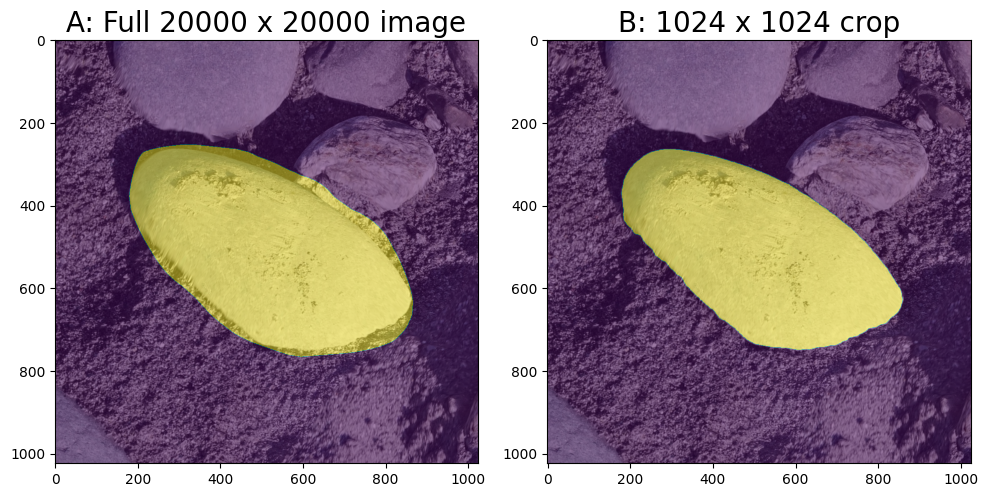

In [17]:
plt.figure(figsize=(10,5))
id=2012
y,x=np.mean(np.where((id_mask==id)),axis=1)
x0,y0=int(x),int(y)

gc.collect()
torch.cuda.empty_cache()
sam = sam_model_registry[MODEL_TYPE](checkpoint='/DATA/vito/MetaSAM/sam_vit_b_01ec64.pth')
sam.to(device=DEVICE)
predictor = SamPredictor(sam)
predictor.set_image(image)

input_point = np.array([[int(x0),int(y0)]])
input_label = np.array([1])

gc.collect()
torch.cuda.empty_cache()

partmasks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,)
best_idx=np.argmax(scores)#pick the mask with highest score
mask=partmasks[best_idx].astype('bool')

plt.subplot(1,2,1)
plt.imshow(image[y0-512:y0+512,x0-512:x0+512])
plt.imshow(mask[y0-512:y0+512,x0-512:x0+512], alpha=0.5)
plt.title('A: Full 20000 x 20000 image', fontsize=20)

gc.collect()
torch.cuda.empty_cache()
sam = sam_model_registry[MODEL_TYPE](checkpoint='/DATA/vito/MetaSAM/sam_vit_b_01ec64.pth')
sam.to(device=DEVICE)
predictor = SamPredictor(sam)
predictor.set_image(image[y0-512:y0+512,x0-512:x0+512])

input_point = np.array([[int(512),int(512)]])
input_label = np.array([1])

gc.collect()
torch.cuda.empty_cache()

partmasks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,)
best_idx=np.argmax(scores)#pick the mask with highest score
mask=partmasks[best_idx].astype('bool')

plt.subplot(1,2,2)
plt.imshow(image[y0-512:y0+512,x0-512:x0+512])
plt.imshow(mask, alpha=0.5)
plt.title('B: 1024 x 1024 crop', fontsize=20)
plt.tight_layout()

/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/DATA/vito/.venv/li

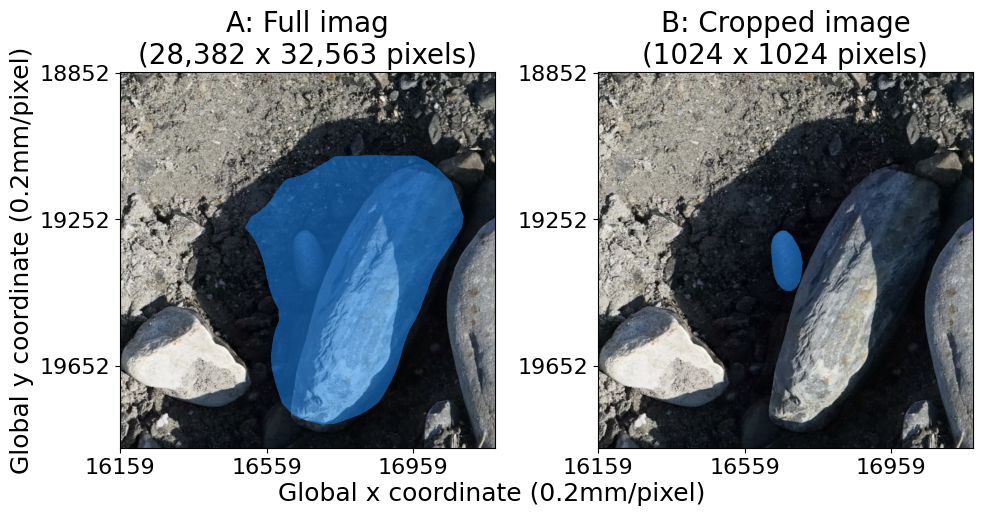

In [18]:
id=2536#2485/879/2134

plt.figure(figsize=(10,5))
y,x=np.mean(np.where((id_mask==id)),axis=1)
x0,y0=int(x),int(y)

gc.collect()
torch.cuda.empty_cache()
sam = sam_model_registry[MODEL_TYPE](checkpoint='/DATA/vito/MetaSAM/sam_vit_b_01ec64.pth')
sam.to(device=DEVICE)
predictor = SamPredictor(sam)
predictor.set_image(image)

input_point = np.array([[int(x0),int(y0)]])
input_label = np.array([1])

gc.collect()
torch.cuda.empty_cache()

partmasks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,)
best_idx=np.argmax(scores)#pick the mask with highest score
mask=partmasks[best_idx].astype('bool')

plt.subplot(1,2,1)
plt.imshow(image[y0-512:y0+512,x0-512:x0+512])
#plt.imshow(mask[y0-512:y0+512,x0-512:x0+512], alpha=0.5)
fnc.show_mask(mask[y0-512:y0+512,x0-512:x0+512], plt.gca())
x_ticks = plt.xticks()[0] 
y_ticks = plt.yticks()[0]
new_x_ticks = x_ticks[1:-1:2]  
new_y_ticks = y_ticks[1:-1:2]  
x_labels = new_x_ticks + x0 - 512  
y_labels = new_y_ticks + y0 - 512  
plt.xticks(new_x_ticks, labels=x_labels.astype(int), fontsize=16)  
plt.yticks(new_y_ticks, labels=y_labels.astype(int), fontsize=16)  

plt.title('A: Full imag\n(28,382 x 32,563 pixels)', fontsize=20)
plt.ylabel("Global y coordinate (0.2mm/pixel)", fontsize=18)

gc.collect()
torch.cuda.empty_cache()
sam = sam_model_registry[MODEL_TYPE](checkpoint='/DATA/vito/MetaSAM/sam_vit_b_01ec64.pth')
sam.to(device=DEVICE)
predictor = SamPredictor(sam)
predictor.set_image(image[y0-512:y0+512,x0-512:x0+512])

input_point = np.array([[int(512),int(512)]])
input_label = np.array([1])

gc.collect()
torch.cuda.empty_cache()

partmasks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,)
best_idx=np.argmax(scores)#pick the mask with highest score
mask=partmasks[best_idx].astype('bool')

plt.subplot(1,2,2)
plt.imshow(image[y0-512:y0+512,x0-512:x0+512])
#plt.imshow(mask, alpha=0.5)
fnc.show_mask(mask, plt.gca())
x_ticks = plt.xticks()[0] 
y_ticks = plt.yticks()[0]
new_x_ticks = x_ticks[1:-1:2]  
new_y_ticks = y_ticks[1:-1:2]  
x_labels = new_x_ticks + x0 - 512  
y_labels = new_y_ticks + y0 - 512  
plt.xticks(new_x_ticks, labels=x_labels.astype(int), fontsize=16)  
plt.yticks(new_y_ticks, labels=y_labels.astype(int), fontsize=16)  

plt.title('B: Cropped image\n(1024 x 1024 pixels)', fontsize=20)
plt.figtext(0.5, 0.01, 'Global x coordinate (0.2mm/pixel)', ha='center', fontsize=18)
plt.tight_layout(rect=[0,0.06,1,0.99])
plt.savefig('/DATA/vito/fig/internal_resize_impact.png')